In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jpholiday

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
#import ydata_profiling
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import torch
from pytorch_lightning import Trainer
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("stock_price.csv")

In [3]:
def convert_volume_with_apply(volume_str):
    """
    出来高の文字列を数値に変換する関数
    """
    if pd.isna(volume_str):
        return np.nan

    volume_str = str(volume_str)

    # 右端の文字で単位を判定
    last_char = volume_str[-1]

    if last_char == 'M':  # ミリオン
        return float(volume_str[:-1]) * 1_000_000
    elif last_char == 'B':  # ビリオン
        return float(volume_str[:-1]) * 1_000_000_000
    elif last_char == 'K':  # キロ
        return float(volume_str[:-1]) * 1_000
    else:  # 単位なし
        return float(volume_str)

【データ理解　EDA】

In [4]:
df.describe()

,終値,始値,高値,安値
count,9202.000000,9202.000000,9202.000000,9202.000000
mean,92.180961,92.256183,93.176451,91.330146
std,50.452228,50.598215,51.049837,50.087405
min,33.000000,33.000000,33.200000,32.200000
25%,52.000000,52.100000,52.800000,51.500000
50%,85.100000,85.100000,86.050000,84.200000
75%,110.800000,110.800000,111.900000,109.275000
max,305.900000,309.800000,311.800000,303.900000


In [5]:
#### --> EDA用レポート表示
#ydata_profiling.ProfileReport(df)

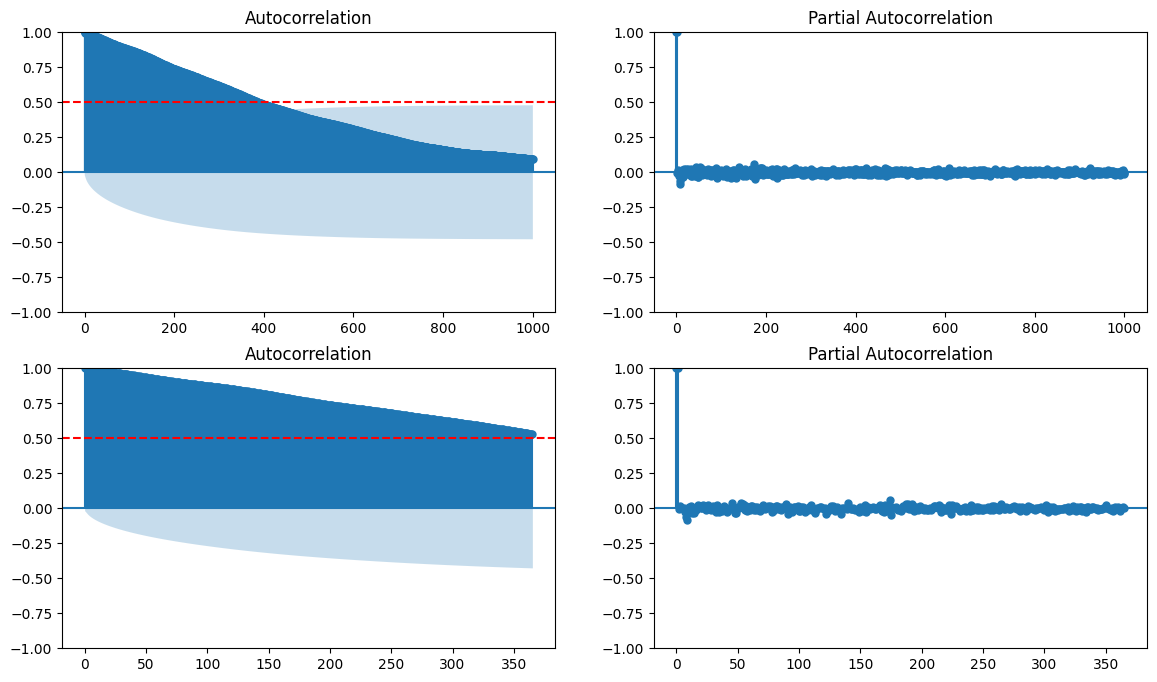

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(14,8))
plot_acf(df["終値"], ax=ax[0, 0], lags=1000)
ax[0,0].axhline(y=0.5, color='red', linestyle='--')

plot_pacf(df["終値"], ax=ax[0, 1], lags=1000)

plot_acf(df["終値"], ax=ax[1, 0], lags=365)
ax[1,0].axhline(y=0.5, color='red', linestyle='--')

plot_pacf(df["終値"], ax=ax[1, 1], lags=365)
plt.show()

【前処理と特徴量エンジニアリング】

In [7]:
#### --> 出来高列の前処理
df["出来高"].str[-1].unique()
df['出来高'] = df['出来高'].apply(convert_volume_with_apply)

#### --> 変化率列の前処理
df["変化率 %"] = df["変化率 %"].str.replace("%", "").astype(float) / 100

#### --> 日付け列の前処理
#日付け列をdatetime型に変換
df["日付け"] = pd.to_datetime(df["日付け"])
print(df.dtypes)

#日付を並び替え
df = df.sort_values("日付け", ascending=True).reset_index(drop=True)


日付け      datetime64[ns]
終値              float64
始値              float64
高値              float64
安値              float64
出来高             float64
変化率 %           float64
dtype: object


In [8]:
#### --> 日付け列の内容確認(歯抜け)
start_date = df["日付け"].min()
end_date = df["日付け"].max()
sample_dates = pd.date_range(start=start_date, end=end_date)

df_dates_set = set(df["日付け"])

# sample_datesにあるが、df_dates_setにはない日付をリスト化
missing_dates = [date for date in sample_dates if date not in df_dates_set]

# 結果を表示
if len(missing_dates) > 0:
    print(f"\n欠損の日付count : {len(missing_dates)}")
else:
    print("欠損している日付はありません。")

#
df_missing_dates = pd.DataFrame(missing_dates, columns=["欠損日"])
df_missing_dates["曜日"] = df_missing_dates["欠損日"].dt.day_name()
#土日の行に欠損があるかどうかの確認 
df_weekdays = df_missing_dates.loc[(df_missing_dates['曜日'] != 'Saturday') & (df_missing_dates['曜日'] != 'Sunday')]
#祝日の行に欠損があるかどうかの確認
df_weekdays['祝日'] = df_weekdays['欠損日'].apply(jpholiday.is_holiday)
#祝日ではない行に欠損があるかどうかの確認(81件)
df_missing = df_weekdays.loc[df_weekdays['祝日'] == False]

print(f"祝日の日付count : {len(df_weekdays)-len(df_missing)}")
print(f"単純欠損の日付count : {len(df_missing)}")




欠損の日付count : 4484
祝日の日付count : 493
単純欠損の日付count : 81


【モデルの実装】　Prophet

In [9]:
m = Prophet()

In [ ]:
sampling_term = 30

target = "終値"
sample = df[["日付け",target]]
sample_test = sample.tail(sampling_term)
sample_train = sample.rename(columns={"日付け": "ds", target: "y"}).drop(sample_test.index)
m.fit(sample_train)

13:27:17 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
future = sample_test[["日付け"]].rename(columns={"日付け":"ds"})

#予測値の算出
forecast = m.predict(future)

In [ ]:
#評価(MAPE)
y_pred = forecast["yhat"]
y_test = sample_test[target]
mape_score = mean_absolute_percentage_error(y_pred,y_test)
print(f"MAPE : {mape_score *100:.3f} %")

In [ ]:
# グラフを描画するaxオブジェクトを作成
fig, ax = plt.subplots(figsize=(10, 6))

# 1. 予測値をプロット（yhatと信頼区間）
ax.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecast')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')

actual_data = sample.loc[sample['日付け'] >= '2021-12-01']
ax.plot(actual_data['日付け'], actual_data['終値'], 'k.', label='Actual')

ax.set_title('Prophet Forecast with Actual Values')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(loc='lower right')

ax.set_ylim(0, None)

plt.show()

fig2 = m.plot_components(forecast)

汎化性能の検証

In [ ]:
"""
学習期間：過去指定期間
汎化性能用にずらす間隔：3ヶ月ごと
予測する未来の期間：30日分
"""
total_rows = len(df)
#initial_days = total_rows - sampling_term
initial_days = 1460
period = 180
horizon = 30

df_cv = cross_validation(m, initial=f'{initial_days} days', period=period, horizon=horizon)

In [ ]:
# ホライズンごとのMAPE, RMSEなどを計算
df_p = performance_metrics(df_cv, metrics=['mape'])

# 結果の確認
print(df_p)

【モデルの実装】　TFT (Temporal Fusion Transformer)

In [ ]:
#IDの付与
df["ID"] = "01"
df["time_idx"] = df["日付け"].factorize()[0] 

# PyTorch 側で MPS デバイス確認
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

#変数定義(短期トレンドを追いかけれるように90日で定義)
pred_length = 30
max_encoder_length = 90

#学習データと検証データの分割
df_test = df.tail(pred_length)
df_train = df.drop(df.tail(pred_length).index)

df_train, df_val = train_test_split(df_train, test_size=0.2)

#学習データ作成
train = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",
    target=target,
    group_ids=["ID"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=pred_length,
    max_prediction_length=pred_length,
    time_varying_known_reals=["出来高", "変化率 %"],
    target_normalizer=NaNLabelEncoder(),
    allow_missing_timesteps=True 
)

#検証データ作成
val = TimeSeriesDataSet(
    df_val,
    time_idx="time_idx",
    target=target,
    group_ids=["ID"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=pred_length,
    max_prediction_length=pred_length,
    time_varying_known_reals=["出来高", "変化率 %"],
    target_normalizer=NaNLabelEncoder(),
    allow_missing_timesteps=True 
)

# データローダー作成
train_dataloader = train.to_dataloader(train=True, batch_size=32)
val_dataloader = val.to_dataloader(train=False, batch_size=32)

#=== モデル定義 ===
tft = TemporalFusionTransformer.from_dataset(
    train,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.1,
    learning_rate=1e-3,
    loss=QuantileLoss(),
)

#=== 学習 ===
trainer = Trainer(
    max_epochs=50,
    accelerator="auto",
    devices=1,
    callbacks=[
        EarlyStopping(       # early_stopping
            monitor="val_loss",
            patience=10,     # 10エポック改善なしで停止
            mode="min"
        )
    ]
)
trainer.fit(tft, train_dataloader, val_dataloader) 

#=== 予測 ===
raw_predictions, x = tft.predict(val_dataloader, return_x=True)


In [ ]:
predictions = tft.transform_output(raw_predictions, target_scale=x["target_scale"])
